In [14]:
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import seaborn as sn

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

In [382]:
from covid_detector.evaluate_covid19 import Evaluator

/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nin

### Functions for prediction of video label

In [37]:
def majority_vote(preds, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds = np.asarray(preds)
    gt = np.asarray(gt)
    vids = np.asarray([vid.split(".")[0] for vid in vid_filenames])
    vid_preds_out = []
    for v in np.unique(vids):
        preds_video = preds[vids==v]
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        labs, pred_counts = np.unique(preds_video, return_counts=True)
        # take label that is predicted most often
        vid_pred = labs[np.argmax(pred_counts)]
        # print("preds for video:", preds_video)
        # print(v, vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    # print("video accuracy (majority):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out
        
def average_certainty(preds_logits, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds_logits = np.asarray(preds_logits)
    gt = np.asarray(gt)
    vid_preds_out = []
    vids = np.array([vid.split(".")[0] for vid in vid_filenames])
    for v in np.unique(vids):
        preds_video_logits = preds_logits[vids==v]
        preds_video = np.sum(preds_video_logits, axis=0)
        # print("preds for video:", preds_video)
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        # take label that is predicted most often
        vid_pred = np.argmax(preds_video)
        # print(v, vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    # print("video accuracy (certainty):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out

## Evaluation script for cross validation

In [4]:
saved_logits, saved_gt, saved_files = [], [], []

for i in range(5):
    print("------------- SPLIT ", i, "-------------------")
    # define data input path
    path = "../data_pocus/cross_validation_data/split"+str(i)
    
    train_labels, test_labels, test_files = [], [], []
    train_data, test_data = [], []

    # loop over the image paths (train and test)
    for imagePath in paths.list_images(path):

        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        test_labels.append(label)
        test_data.append(image)
        test_files.append(imagePath.split(os.path.sep)[-1])

    # build ground truth data
    classes = ["covid", "pneunomia", "regular"]
    gt_class_idx = np.array([classes.index(lab) for lab in test_labels])
    
    # load model
    model = Evaluator(split=str(i))
    
    # MAIN STEP: feed through model and compute logits
    logits = np.array([model(img) for img in test_data])
    
    # remember for evaluation:
    saved_logits.append(logits)
    saved_gt.append(gt_class_idx)
    saved_files.append(test_files)
    
    # output the information
    predIdxs = np.argmax(logits, axis=1)
    
    print(
    classification_report(
        gt_class_idx, predIdxs, target_names=classes
        )
    )

    vid_preds_certainty = average_certainty(logits, gt_class_idx, np.array(test_files))
    vid_preds_majority = majority_vote(predIdxs, gt_class_idx, np.array(test_files))
    print("video accuracies:", vid_preds_certainty, vid_preds_majority)

------------- SPLIT  0 -------------------
init
Loading weights from  ../trained_models/fold_0/variables/variables
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model restored. Class mappings are ['covid', 'pneunomia', 'regular']
              precision    recall  f1-score   support

       covid       0.70      0.56      0.62        63
   pneunomia       0.71      0.79      0.75        28
     regular       0.67      0.81      0.74        48

    accuracy                           0.69       139
   macro avg       0.69      0.72      0.70       139
weighted avg       0.69      0.69      0.69       139

preds for video: [0.41692764 5.862566   2.720506  ]
Cov-Atlas+(44) 1 0
preds for video: [0.2946806 1.1493942 3.5559251]
Cov-Atlas+(45) 2 0
preds for video: [0.2536777 2.318747  5.4275756]
Cov-Atlas-+(43) 2 0
preds for video: [1.0876949  0.30086467 

### Save outputs

In [6]:
import pickle
with open("eval.dat", "wb") as outfile:
    pickle.dump((saved_logits, saved_gt, saved_files), outfile)

### Load outputs

In [20]:
import pickle
with open("eval.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)

## Compute scores of our model

### Sum up confusion matrices

In [21]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

### Compute the reports and accuracies

In [22]:
classes = ["covid", "pneunomia", "regular"]

all_reports = []
accs = []
bal_accs = []
for s in range(5):
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    report = classification_report(
        gt_s, pred_idx_s, target_names=classes, output_dict=True
        )
    df = pd.DataFrame(report).transpose()
    #print(report["accuracy"])
    # print(np.array(df)[:3,:])
    accs.append(report["accuracy"])
    bal_accs.append(balanced_accuracy_score(gt_s, pred_idx_s))
    # df = np.array(report)
    all_reports.append(np.array(df)[:3])

### Output accuracy

In [23]:
print("The accuracy and balanced accuracy of our model are:")
print(np.around(accs,2),np.around(bal_accs,2))
print("MEAN ACC:", round(np.mean(accs), 2), "MEAN BAL ACC:", round(np.mean(bal_accs),2))

The accuracy and balanced accuracy of our model are:
[0.69 0.99 1.   0.94 0.62] [0.72 1.   1.   0.94 0.6 ]
MEAN ACC: 0.85 MEAN BAL ACC: 0.85


## Make table of results distinguished by classes

#### Helper functions

In [24]:
def comp_nr_videos(saved_files):
    file_list = []
    for sav in saved_files:
        file_list.extend(sav)
    assert len(np.unique(file_list)) == len(file_list)
    cutted_files = [f.split(".")[0] for f in file_list]
    print("number of videos", len(np.unique(cutted_files)))
    vid_file_labels = [v[:3].lower() for v in np.unique(cutted_files)]
    print(len(vid_file_labels))
    print(np.unique(vid_file_labels, return_counts=True))
    lab, counts = np.unique(vid_file_labels, return_counts=True)
    return counts.tolist()

def compute_specificity(all_cms):
    """
    Function to compute the specificity from confusion matrices
    all_cms: array of size 5 x 3 x 3 --> confusion matrix for each fold
    """
    specificities_fold = []
    for k in range(len(all_cms)):
        arr = all_cms[k]
        overall = np.sum(arr)
        specificity = []
        for i in range(len(arr)):
            tn_fp = overall - np.sum(arr[i])
            # print(bottom_six)
            fp = 0
            for j in range(len(arr)):
                if i!=j:
                    fp += arr[j, i]
            spec = (tn_fp-fp)/tn_fp
            # print("tn", tn_fp-fp, "tn and fp:", tn_fp)
            # print(spec)
            specificity.append(spec)
        specificities_fold.append(specificity)
    out_spec = np.mean(np.asarray(specificities_fold), axis=0)
    return np.around(out_spec, 2)

In [25]:
df_arr = np.around(np.mean(all_reports, axis=0), 2)

In [26]:
df_classes = pd.DataFrame(df_arr, columns=["Precision", "Recall", "F1-score", "Support"], index=["covid","pneunomia", "regular"])


#### Add specificit, number of frames etc

In [27]:
df_classes["Specificity"] = np.around(compute_specificity(all_cms),2)
df_classes["Frames"] = np.diag(np.sum(all_cms, axis=0)).astype(int).tolist()
df_classes["Videos/Images"] = comp_nr_videos(saved_files)
df_classes = df_classes.drop(columns=["Support"])

number of videos 45
45
(array(['cov', 'pne', 'reg'], dtype='<U3'), array([20, 11, 14]))


In [28]:
df_classes
# negative predictive value --> gegenstueck zu precision
# specificity --> gegenstück zu recall

,Precision,Recall,F1-score,Specificity,Frames,Videos/Images
covid,0.87,0.82,0.84,0.87,371,20
pneunomia,0.92,0.93,0.92,0.98,122,11
regular,0.75,0.80,0.77,0.90,158,14


## Comparison to Covid-Net

Manually copied data from txt fil

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [29]:
cm0 = np.array([[24., 12., 12.], [ 0., 28.,  0.], [29.,  4., 30.]])
cm1 = np.array([[  0.,   1.,  48.],[  0.,  22.,   0.],[  0.,   2., 109.]])
cm2 = np.array([[17., 5., 13.],[ 2., 24., 0.],[ 0.,  0, 94.]])
cm3 = np.array([[30., 0., 0.],[ 0., 25.,  0.],[ 3., 0, 85.]])
cm4 = np.array([[19., 0., 8.],[ 6., 25., 0.], [ 0.,  0., 80.]])

# sensitivities
sens_reg = np.mean([0.5, 0, 0.486, 1.0, 0.704])
sens_pneu = np.mean([1.0, 1.0, 0.923, 1.0, 0.806])
sens_covid = np.mean([0.476, 0.982, 1.0, 0.966, 1.0])
# precisions
prec_reg = np.mean([0.453, 0, 0.895, 0.909, 0.76])
prec_pneu = np.mean([0.636, 0.88, 0.828, 1.0, 1.0])
prec_covid = np.mean([0.714, 0.694, 0.879, 1.0, 0.909])

accs_covidnet = [0.58992805, 0.719, 0.871, 0.979, 0.89855]

all_cms_cov_model = np.array([cm0, cm1, cm2, cm3, cm4])
print(all_cms_cov_model.shape)

(5, 3, 3)


In [30]:
def f_measure(prec, rec):
    return (2*prec*rec)/(prec+rec)

#### Output accuracy and balanced accuracy

In [31]:
added_cms_cov_net = np.sum(all_cms_cov_model, axis=0)
bal_acc_covidnet = np.diag(added_cms_cov_net)/np.sum(added_cms_cov_net, axis=1)
print("The accuracy and balanced accuracy of our model are:")
print(np.around(accs_covidnet,2),np.around(bal_acc_covidnet,2))
print("MEAN ACC:", round(np.mean(accs_covidnet), 2), "MEAN BAL ACC:", round(np.mean(bal_acc_covidnet),2))

The accuracy and balanced accuracy of our model are:
[0.59 0.72 0.87 0.98 0.9 ] [0.48 0.94 0.91]
MEAN ACC: 0.81 MEAN BAL ACC: 0.78


#### Make similar table for covid-net

In [32]:
df_classes["Class"] = df_classes.index
df_classes.index = ["our model", "our model","our model"]
df_cov = df_classes.copy()
df_cov.index = ["covid-net", "covid-net", "covid-net"]
df_cov["Precision"] = np.around([prec_covid, prec_pneu, prec_reg], 2).tolist()
df_cov["Recall"] = np.around([sens_covid, sens_pneu, sens_reg], 2).tolist()
sens = np.array(compute_specificity(all_cms_cov_model))[[2,1,0]]
df_cov["Specificity"] = sens.tolist()
df_cov["F1-score"] = np.around([f_measure(p, r) for (p,r) in zip(df_cov["Precision"], df_cov["Recall"])], 2)

In [33]:
df_cov

,Precision,Recall,F1-score,Specificity,Frames,Videos/Images,Class
covid-net,0.84,0.88,0.86,0.76,371,20,covid
covid-net,0.87,0.95,0.91,0.96,122,11,pneunomia
covid-net,0.60,0.54,0.57,0.92,158,14,regular


#### Merge both tables and output final table as latex

In [34]:
results_together = pd.concat([df_classes, df_cov])
results_together["Sensitivity"] = results_together["Recall"]
results_together = results_together[["Class", "Sensitivity", "Specificity", "Precision", "F1-score", "Frames", "Videos/Images"]]
print(results_together.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &      Class &  Sensitivity &  Specificity &  Precision &  F1-score &  Frames &  Videos/Images \\
\midrule
our model &      covid &         0.82 &         0.87 &       0.87 &      0.84 &     371 &             20 \\
our model &  pneunomia &         0.93 &         0.98 &       0.92 &      0.92 &     122 &             11 \\
our model &    regular &         0.80 &         0.90 &       0.75 &      0.77 &     158 &             14 \\
covid-net &      covid &         0.88 &         0.76 &       0.84 &      0.86 &     371 &             20 \\
covid-net &  pneunomia &         0.95 &         0.96 &       0.87 &      0.91 &     122 &             11 \\
covid-net &    regular &         0.54 &         0.92 &       0.60 &      0.57 &     158 &             14 \\
\bottomrule
\end{tabular}



In [35]:
results_together

,Class,Sensitivity,Specificity,Precision,F1-score,Frames,Videos/Images
our model,covid,0.82,0.87,0.87,0.84,371,20
our model,pneunomia,0.93,0.98,0.92,0.92,122,11
our model,regular,0.80,0.90,0.75,0.77,158,14
covid-net,covid,0.88,0.76,0.84,0.86,371,20
covid-net,pneunomia,0.95,0.96,0.87,0.91,122,11
covid-net,regular,0.54,0.92,0.60,0.57,158,14


## Compute video accuracy

In [38]:
def preds_to_score(vid_preds_out):
    return accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out])
    
scores_certainty = []
scores_majority = []
for i in range(len(saved_files)):
    vid_preds_certainty = average_certainty(saved_logits[i], saved_gt[i], saved_files[i])
    vid_preds_majority = majority_vote(np.argmax(saved_logits[i], axis=1), saved_gt[i], saved_files[i])
    scores_certainty.append(preds_to_score(vid_preds_certainty))
    scores_majority.append(preds_to_score(vid_preds_majority))

## Confusion matrix plots

#### Load the results

In [6]:
with open("eval.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)

#### Sum up confusion matrices

In [7]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

#### Function to make labels with std from the data

In [8]:
def data_to_label(data, text):
    return (np.asarray(["{0:.2f}\n".format(data)+u"\u00B1"+"{0:.2f}".format(text) for data, text in zip(data.flatten(), text.flatten())])).reshape(3,3)

#### Make figure

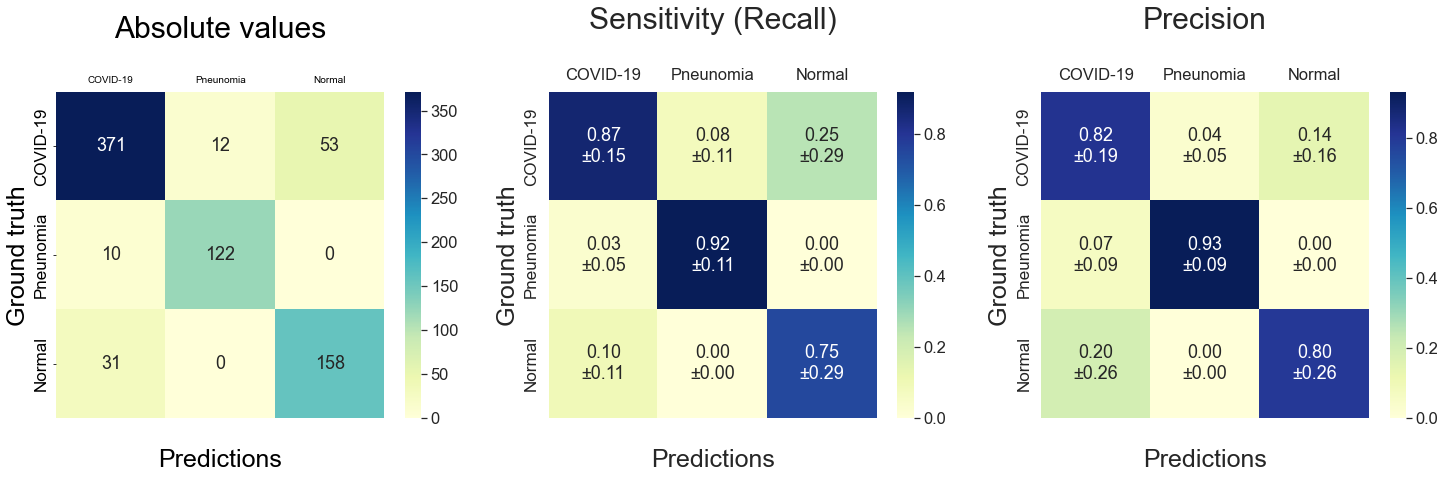

In [12]:
plt.figure(figsize = (25,6))
fig = plt.subplot(1,3,1)
ax = fig.axes

data_abs = np.sum(all_cms, axis=0)
df_cm = pd.DataFrame(data_abs, index = [i for i in ["COVID-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["COVID-19", "Pneunomia", "Normal"]])

sn.set(font_scale=1.5)
#plt.xticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=True, fmt="g", cmap="YlGnBu")
ax.xaxis.tick_top()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Absolute values\n", size=30)


# PRECISION SUBPLOT
fig = plt.subplot(1,3,2)
ax = fig.axes


data_prec = all_cms.copy()
for i in range(5):
    data_prec[i] = data_prec[i]/np.sum(data_prec[i], axis=0)
prec_stds = np.std(data_prec, axis = 0)
data_prec = np.mean(data_prec, axis=0)
labels_prec = data_to_label(data_prec, prec_stds)

df_cm = pd.DataFrame(data_prec, index = [i for i in ["COVID-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["COVID-19", "Pneunomia", "Normal"]])
sn.set(font_scale=1.5)
plt.ylabel("ground truth")
plt.xlabel("predictions")
plt.title("Precision")
ax.xaxis.tick_top()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=labels_prec, fmt='', cmap="YlGnBu")
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Sensitivity (Recall)\n", size=30)


#  SENSITIVITY SUBPLOT
fig = plt.subplot(1,3,3)
ax = fig.axes
data_sens = all_cms.copy()
for i in range(5):
    sums_axis = np.sum(data_sens[i], axis=1)
    data_sens[i] = np.array([data_sens[i,j,:]/sums_axis[j] for j in range(3)])
sens_stds = np.std(data_sens, axis = 0)
data_sens = np.mean(data_sens, axis=0)

labels_sens = data_to_label(data_sens, sens_stds)
df_cm = pd.DataFrame(data_sens, index = [i for i in ["COVID-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["COVID-19", "Pneunomia", "Normal"]])
# sn.set(font_scale=1.5)

plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
#plt.xticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
ax.xaxis.tick_top()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 



sn.heatmap(df_cm, annot=labels_sens, fmt='', cmap="YlGnBu")
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Precision\n", size=30)

plt.savefig("confusion_matrix.pdf", bottom=0.2)



## ROC AUC

In [40]:
with open("eval.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score

### Compute scores and curve

In [42]:
data, scores, roc_auc_std = [], [], []
max_points = []
for i in range(3):
    precs = [[] for _ in range(5)]
    recs = [[] for _ in range(5)]
    julie_points = [[] for _ in range(5)]
    roc_auc = []
    for j in range(5):
        # roc auc score
        preds = saved_logits[j][:, i]
        gt = (saved_gt[j] == i).astype(int)
        roc_auc.append(roc_auc_score(gt, preds))
        # compute roc curve
        for k in np.linspace(0,1.1,100):
            preds_thresholded = (preds>k).astype(int)
            tp = np.sum(preds_thresholded[gt==1])
            p = np.sum(gt)
            n = len(gt)-p
            fp = np.sum(preds_thresholded[gt==0])
            inverted = np.absolute(preds_thresholded - 1)
            tn = np.sum(inverted[gt==0])
            fn = np.sum(inverted[gt==1])
            fpr = fp/n
            tpr = tp/p
            precs[j].append(fpr)
            recs[j].append(tpr)
            julie_points[j].append((tp+tn)/(tp+tn+fp+fn)) # (TP+TN)/(TP+TN+FN+FP)
            # precs[j].append(precision_score(gt, preds_thresholded))
            # recs[j].append(recall_score(gt, preds_thresholded))
        
    # append scores
    scores.append(round(np.mean(roc_auc),2))
    roc_auc_std.append(round(np.std(roc_auc),2))
    # take mean and std of fpr and tpr
    stds = np.std(np.asarray(recs), axis=0)
    precs = np.mean(np.asarray(precs), axis=0)
    recs = np.mean(np.asarray(recs), axis=0)
    # point of maximum accuracy
    julie_points = np.mean(np.asarray(julie_points), axis=0)
    max_points.append(np.argmax(julie_points))
    data.append((precs, recs, stds))

In [43]:
plt.rcParams['legend.title_fontsize'] = 15
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=False)

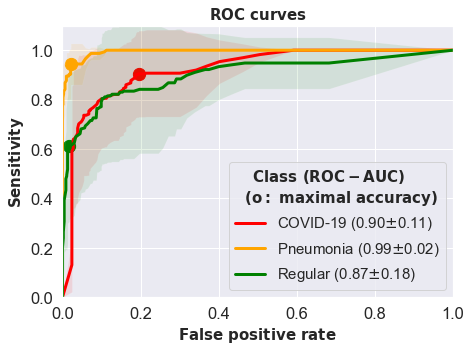

In [44]:
cols = ["red", "orange", "green"]
classes = ["COVID-19", "Pneumonia", "Regular"]
# roc_auc_scores = np.mean(np.asarray(scores), axis=0)
plt.figure(figsize=(7,5))
for i in range(3):
    p, r, s = data[i]
    # sns.lineplot(x=p, y=r)
    # plt.plot(p, r,label=classes[i])
    # plt.plot(p,r-s)
    lab = classes[i]+" (%.2f"%scores[i]+"$\pm$"+str(roc_auc_std[i])+")"
    plt.plot(p, r, 'k-', c=cols[i], label=lab, lw=3)
    # print(len(r), max_points[i])
    plt.scatter(p[max_points[i]], r[max_points[i]], s=150, marker="o", c=cols[i])
    plt.fill_between(p, r-s, r+s, alpha=0.1, facecolor=cols[i])
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.ylabel("$\\bf{Sensitivity}$", fontsize=15)
plt.xlabel("$\\bf{False\ positive\ rate}$", fontsize=15)
plt.legend(fontsize=15, title="    $\\bf{Class}\ \\bf(ROC-AUC)}$\n  $\\bf{(o:\ maximal\ accuracy)}$")
plt.title("$\\bf{ROC\ curves}$", fontsize=15)
plt.savefig("roc_curves.pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

### Compute roc-auc score

In [45]:
print(scores, roc_auc_std)

[0.9, 0.99, 0.87] [0.11, 0.02, 0.18]
